# Common

These sections include code common to both ResNet and Inception.

## Dependencies

Let's setup and configure dependencies. Note that since torchviz is used, graphviz needs to be specially installed.

In [1]:
%load_ext tensorboard

import contextlib
from functools import lru_cache
from io import BytesIO
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from PIL import Image
import random
import time
import timm
import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.datasets as datasets
from torchvision.io import ImageReadMode
from torchvision.io import read_image
from torchvision import transforms as T
from torchviz import make_dot # This requires external downloads as well
import tqdm

In [2]:
# Reproducibility
def seed_worker(worker_id):
    """
    Sets the seed of the worker to depend on the initial seed. Credit to
    https://pytorch.org/docs/stable/notes/randomness.html
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
torch.manual_seed(0)
# For DataLoaders
g = torch.Generator().manual_seed(0)

In [3]:
# Prepare progress bar
tqdm_variant = tqdm.tqdm # Assume not in Jupyter
try:
    # Credit https://stackoverflow.com/a/39662359
    shell_name = get_ipython().__class__.__name__
    if shell_name == "ZMQInteractiveShell":
        # Case in Jupyter
        tqdm_variant = tqdm.notebook.tqdm
except NameError:
    # Probably no iPhython instance, just use standard
    pass

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Plotting and Debugging Tools

Let's create some helpful functions for plotting.

In [5]:
# Adapted from Steven's ModelExamples
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [6]:
def plot_cumulative_dist(
    baseline_observations,
    stabilized_observations
):
    """Plot our reproduction of Figure 7."""
    fig, ax = plt.subplots()
    ax.set_title("Cumulative Distributions")
    ax.set_xlabel("Feature Distance", fontweight="bold", loc="left")
    ax.set_ylabel("Cumulative Fraction", fontweight="bold", loc="top")
    ax.hist(
        baseline_observations,
        round(np.sqrt(len(baseline_observations))),
        density=True,
        histtype="step",
        cumulative=True,
        label="Baseline"
    )
    if len(stabilized_observations) > 0:
        ax.hist(
            stabilized_observations,
            round(np.sqrt(len(stabilized_observations))),
            density=True,
            histtype="step",
            cumulative=True,
            label="Stabilized"
        )
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.tick_params(axis="x", direction="in", pad=-15)
    ax.tick_params(axis="y", direction="in", pad=-22)
    ax.set_yticks([0.2,0.4,0.6,0.8,1.0])
    ax.set_yticklabels(
        ["20%","40%","60%","80%","100%"],
        {"fontweight" : "bold", "verticalalignment" : "top"}
    )
    ax.legend(loc="upper left")
    ax.grid()
    fig.savefig(
        os.path.join(
            os.path.abspath(""),
            f"cumulative_dists_{int(time.time()) % 1000000:06}.png"
        )
    )
    fig.show()

In [7]:
def show_first_triplet(queries, positives, negatives):
    a, b, c = queries[0], positives[0], negatives[0]
    ToPIL = T.ToPILImage() # Converting function
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(ToPIL(a))
    ax[1].imshow(ToPIL(b))
    ax[2].imshow(ToPIL(c))
    fig.show()

In [8]:
def debug_distances(triplet_ranking_model, batch, item_idx=0):
    with torch.no_grad():
        output = triplet_ranking_model(*map(lambda x : x.to(device), batch))
        qfeat = output[item_idx][0]
        pfeat = output[item_idx][1]
        nfeat = output[item_idx][2]
        pos_dist = torch.sqrt(((qfeat - pfeat)**2).sum()).item()
        neg_dist = torch.sqrt(((qfeat - nfeat)**2).sum()).item()
        print(f"Distance to positive: {pos_dist}, to negative: {neg_dist}")

This part is also helpful for storing results of training:

In [9]:
def _def_save_filename(iteration_number : int, is_model : bool):
    """
    Returns a save filename from an iteration number, and whether the
    thing being saved is the model or the loss progress.
    """
    # Make sure inputs are okay (no directory traversal attacks!)
    if not isinstance(iteration_number, int):
        raise TypeError("Iteration number should be an integer.")

    # Retrieve proper name
    if is_model:
        return os.path.join(
            os.path.dirname(os.path.abspath("")),
            f"model_save_{iteration_number}_{int(time.time())%1000000:06}.pt"
        )
    return os.path.join(
        os.path.dirname(os.path.abspath("")),
        f"progress_save_{iteration_number}_{int(time.time())%1000000:06}.pt"
    )

#
# This class will make recording information easier
#
class TrainResult:
    """
    Hold the results of a training round. Basically a nice wrapper.

    Losses and accuracies should be averages over a batch for plot
    labels to make sense.

    Use whichever storage makes sense, but if one doesn't use the
    storage then don't expect the corresponding plots to do anything.
    """

    def __init__(self, model):
        """
        Constructor - prepare local variables. Include model since the
        one provided to trainer will likely be moved to a different
        device. Provide the one that is actually trained here, and then
        it can be used.
        """
        self.train_loss_history = []
        self.val_loss_history = []
        self.train_accuracy_history = []
        self.val_accuracy_history = []
        self.time_training = 0.0
        self.time_validating = 0.0
        self.model = model

    def plot_loss_train_valid_curves(self, ax, show_legend : bool=True):
        """Use matplotlib to show training curves. Supply axis in ax."""
        ax.plot(self.train_loss_history, label="Train")
        ax.plot(self.val_loss_history, label="Test")
        ax.set_title(f"Model Loss")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        if show_legend:
            ax.legend()

    def plot_accuracy_train_valid_curves(self, ax, show_legend=True):
        """Use matplotlib to show training curves. Supply axis in ax."""
        ax.plot(self.train_accuracy_history, label="Train")
        ax.plot(self.val_accuracy_history, label="Test")
        ax.set_title(f"Model Accuracy")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Accuracy")
        if show_legend:
            ax.legend()

    def print_time_info(self):
        """Prints some lines with information about timing."""
        print(f"Spent {round(self.time_training)} seconds training.")
        print(f"Spent {round(self.time_validating)} seconds evaluating.")

    def full_analysis(self, axs):
        """Display all analysis plots and print time information."""
        if len(self.train_loss_history) > 0:
            self.plot_loss_train_valid_curves(axs[0])
        if len(self.train_accuracy_history) > 0:
            self.plot_accuracy_train_valid_curves(axs[1])
        if self.time_training > 0.0:
            self.print_time_info()

    def save(self, save_filename_func, count : int=0):
        """
        Uses the save_filename_func provided with the count to create
        files that save the models current weights and the training
        progress so far.

        For count, 0 is by convention the final version.
        """
        # Save model
        torch.save(self.model.state_dict(), save_filename_func(count, True))
        # Save progress
        with open(save_filename_func(count, False), "wb") as file_obj:
            pickle.dump(
                {
                    "train_loss_history" : self.train_loss_history,
                    "val_loss_history" : self.val_loss_history,
                    "train_accuracy_history" : self.train_accuracy_history,
                    "val_accuracy_history" : self.val_accuracy_history,
                    "time_training" : self.time_training,
                    "time_validating" : self.time_validating
                }, file_obj
            )

## Experiments

Let's make some functions to run experiments on models.

For the following, see how closely the triplet ranking models think compressed versions of the same images are.

In [10]:
def make_observations(baseline_model, stabilized_model, imagefolder):
    """
    Given a model trained for triplet ranking, make duplicate detection
    observations.
    """
    baseline_observations = []
    stabilized_observations = []
    tensor_transform = inception_transform
    
    for img_name in tqdm_variant(os.listdir(imagefolder)):
        #
        # Deal with images
        #
        image_fpath = os.path.join(imagefolder, img_name)
        if "jpeg" in img_name.lower():
            original_img = Image.open(image_fpath).convert("RGB")
        else:
            continue
        # Thanks https://stackoverflow.com/a/30771751
        buffer = BytesIO()
        original_img.save(buffer, "JPEG", optimize=True, quality=50)
        compressed_img = Image.open(buffer).convert("RGB")
        
        orig_tensor = tensor_transform(original_img)
        comp_tensor = tensor_transform(compressed_img)
        orig_tensor = orig_tensor.view(1, *orig_tensor.shape)
        comp_tensor = comp_tensor.view(1, *comp_tensor.shape)
        #
        # Make observations
        #
        baseline_model.eval()
        if stabilized_model is not None:
            stabilized_model.eval()
        with torch.no_grad():
            # Baseline
            original_rep = nn.functional.normalize(baseline_model(orig_tensor))
            compressed_rep = nn.functional.normalize(baseline_model(comp_tensor))
            dist = torch.sqrt(((original_rep - compressed_rep)**2).sum())
            baseline_observations.append(dist)
            # Stabilized
            if stabilized_model is not None:
                original_rep = nn.functional.normalize(stabilized_model(orig_tensor))
                compressed_rep = nn.functional.normalize(stabilized_model(comp_tensor))
                dist = torch.sqrt(((original_rep - compressed_rep)**2).sum())
                stabilized_observations.append(dist)
            
    return baseline_observations, stabilized_observations

## Models

We'll similarly create model objects as we go along, but this section contains things that simplify making them.

### Helper Transformations

In [11]:
# Credit https://discuss.pytorch.org/t/how-to-add-noise-to-mnist-dataset-when-using-pytorch/59745
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return (
            tensor
            + torch.empty(tensor.size(), device=device).normal_() * self.std
            + self.mean
        )
    
    def __repr__(self):
        return (
            self.__class__.__name__
            + '(mean={0}, std={1})'.format(self.mean, self.std)
        )

In [12]:
# Applies an amount of JPEG compression to a PIL image    
class JPEGTransform(nn.Module):
    def __init__(self, quality=50):
        self.quality = quality
    
    def __call__(self, img):
        buffer = BytesIO()
        img.save(buffer, "JPEG", optimize=True, quality=self.quality)
        return Image.open(buffer)

ResNet is made to be used with data transformed as so:

In [13]:
resnet_transform = T.Compose([
    T.Resize((256,256)),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Wrappers

In [14]:
class TripletRanker(nn.Module):
    """Triplet ranking model."""
    
    def __init__(self, model):
        """Creates a triplet ranker out of the model."""
        super().__init__()
        self.model = model
        
        
    def forward(self, queries, positives, negatives):
        """Send batch of triplets through."""
        queries_encode = nn.functional.normalize(self.model(queries))
        positives_encode = nn.functional.normalize(self.model(positives))
        negatives_encode = nn.functional.normalize(self.model(negatives))
        return queries_encode, positives_encode, negatives_encode

In [15]:
class StabilityTrainingModel(torch.nn.Module):
    def __init__(self, other_model, perturbation=None):
        """
        Wraps another model to allow for stability training. May specify
        custom perturbation transformation.
        """
        super().__init__()
        self.model = other_model
        
        if perturbation is None:
            self.perturb = AddGaussianNoise(0, 0.04)
        else:
            self.perturb = perturbation
    
    def forward(self, *x):
        """Apply the model to some input."""
        return self.model(*x), self.model(*[self.perturb(i) for i in x])

## Datasets

Let's prepare some datasets. First, we'll make a custom dataset.

In [16]:
# NOTE: an alternative to this paradigm is loading all the images using
# the transform as a catalogue onto main memory, then detach on access
# TODO - refactor
class TripletRankingDataset(torch.utils.data.Dataset):
    def __init__(self,
                 img_dir : str,
                 pos_per_img : int,
                 neg_per_pos : int,
                 transform=None,
                 training=True
                ):
        """
        Point at directory which has subdirectories corresponding to
        each class. Supply the number of positive images per image in
        the subdirectories and the number of negative images to combine
        with.
        """
        if transform is None:
            transform = nn.Identity()
        self.transform = transform
        self.mode = "RGB"#ImageReadMode.RGB
        
        #
        # Initialize triplets
        #
        self.triplets = [ ]
        
        if training:
            self._train_init(img_dir, pos_per_img, neg_per_pos)
        else:
            self._val_init(img_dir, pos_per_img, neg_per_pos)
        
    def _train_init(self, img_dir, pos_per_img, neg_per_pos):
        # Generate randoms first, index into later. Need to count
        # Iterate over classes
        class_names = os.listdir(img_dir)
        if os.path.exists(os.path.join(img_dir, class_names[0], "images")):
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x, "images"),
                class_names
            ))
        else:
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x),
                class_names
            ))
        for subdir_path in subdirectories_paths:
            img_per_class = len(os.listdir(subdir_path))
            break
        randoms = np.random.randint(
            0,
            img_per_class,
            (
                len(subdirectories_paths),
                img_per_class,
                pos_per_img,
                neg_per_pos + 1 # Last for positive selection
            ),
            dtype="int16"
        )
        
        # TODO - this method inefficient, only need to hold 2 numbers,
        # some string format info
        # DANGER - potential for loops with symbolic/hard links
        # Iterate over classes
        for subdir_idx, subdir_path in enumerate(subdirectories_paths):
            exclude_subdir_idx =  [
                            *range(subdir_idx),
                            *range(
                                subdir_idx + 1,
                                len(subdirectories_paths)
                            )
                        ]
            # Iterate over images
            for img_idx, img in enumerate(os.listdir(subdir_path)):
                img_path = os.path.join(subdir_path, img)
                # Iterate over alike images
                for pos_it in range(pos_per_img):
                    pos_rand = randoms[subdir_idx][img_idx][pos_it][-1]
                    # Adjust on equal
                    if pos_rand == pos_it:
                        if pos_rand == 0:
                            pos_rand += 1
                        else:
                            pos_rand -= 1
                    # Form name
                    pos_path = os.path.join(
                        subdir_path,
                        f"{class_names[subdir_idx]}_{pos_rand}.JPEG"
                    )
                    # Need more randoms for next step
                    neg_class_rands = np.random.choice(
                        exclude_subdir_idx,
                        neg_per_pos,
                        replace=True
                    )
                    # Iterate over dissimilar images
                    for neg_it in range(neg_per_pos):
                        class_rand = neg_class_rands[neg_it]
                        neg_class_path = subdirectories_paths[class_rand]
                        neg_class = class_names[class_rand]
                        neg_rand = randoms[subdir_idx][img_idx][pos_it][neg_it]
                        # Form name
                        neg_path = os.path.join(
                            neg_class_path,
                            f"{neg_class}_{neg_rand}.JPEG"
                        )
                        # Append
                        self.triplets.append((img_path, pos_path, neg_path))
                        
    def _val_init(self, img_dir, pos_per_img, neg_per_pos):
        # Generate randoms first, index into later. Need to count
        # Iterate over classes
        class_names = os.listdir(img_dir)
        
        if os.path.exists(os.path.join(img_dir, class_names[0], "images")):
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x, "images"),
                class_names
            ))
        else:
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x),
                class_names
            ))
            
        img_per_class = dict()
        img_names = []
        for idx in range(len(class_names)):
            subdir_path = subdirectories_paths[idx]
            class_name = class_names[idx]
            img_names.append(list(os.listdir(subdir_path)))
            img_per_class[class_name] = len(img_names[-1])
        
        # TODO - this method inefficient, only need to hold 2 numbers,
        # some string format info
        # DANGER - potential for loops with symbolic/hard links
        # Iterate over classes
        for subdir_idx, subdir_path in enumerate(subdirectories_paths):
            exclude_subdir_idx =  [
                            *range(subdir_idx),
                            *range(
                                subdir_idx + 1,
                                len(subdirectories_paths)
                            )
                        ]
            this_dir = img_names[subdir_idx]
            # Iterate over images
            for img_idx, img in enumerate(this_dir):
                img_path = os.path.join(subdir_path, img)
                # Iterate over alike images
                for pos_it in range(pos_per_img):
                    # Form name
                    rand_idx = np.random.choice([
                        *range(pos_it),
                        *range(pos_it + 1, img_per_class[class_names[pos_it]])
                    ])
                    pos_name = this_dir[rand_idx]
                    # Form path
                    pos_path = os.path.join(subdir_path, pos_name)
                    # Need more randoms for next step
                    neg_class_rands = np.random.choice(
                        exclude_subdir_idx,
                        neg_per_pos,
                        replace=True
                    )
                    # Iterate over dissimilar images
                    for neg_it in range(neg_per_pos):
                        class_rand = neg_class_rands[neg_it]
                        neg_class_path = subdirectories_paths[class_rand]
                        neg_class = class_names[class_rand]
                        # Select from the directory
                        neg_name = np.random.choice(img_names[class_rand])
                        # Form name
                        neg_path = os.path.join(neg_class_path, neg_name)
                        # Append
                        self.triplets.append((img_path, pos_path, neg_path))
        
    def __len__(self):
        return len(self.triplets)
    
    def __getitem__(self, idx):
        this_triplet = self.triplets[idx]
        #query = self.transform(read_image(this_triplet[0], self.mode))
        #positive = self.transform(read_image(this_triplet[1], self.mode))
        #negative = self.transform(read_image(this_triplet[2], self.mode))
        query = self.transform(Image.open(this_triplet[0]).convert(self.mode))
        positive = self.transform(Image.open(this_triplet[1]).convert(self.mode))
        negative = self.transform(Image.open(this_triplet[2]).convert(self.mode))
        return query, positive, negative

The following is helpful to keep around:

In [17]:
data_dir = os.path.join(os.path.abspath(""), "tiny-imagenet-200")

We'll create dataset objects as we go since they take up memory, but these are used across tasks:

## Training Functions

Factoring some common patterns:

In [18]:
def triplet_epoch(
    model,
    loader,
    optimizer,
    device,
    loss_func,
    result,
    training=True
):
    loss = torch.Tensor([0])
    avg_loss = 0
    
    if training:
        model.train()
    else:
        model.eval()
    start = time.perf_counter()
    with contextlib.ExitStack() as stack: # For validation/training
        if not training:
            stack.enter_context(torch.no_grad()) # No gradients
        for queries, positives, negatives in tqdm_variant(
            loader,
            desc=f"{'Training' if training else 'Validation'} Iteration",
            disable=False
        ):
            if training:
                # Prepare optimizer
                optimizer.zero_grad(set_to_none=True)

            # Prepare relevant variables
            queries = queries.to(device)
            positives = positives.to(device)
            negatives = negatives.to(device)
            out = model(queries, positives, negatives)

            # Determine loss
            loss = loss_func(*out)

            # Store intermediate results - note average over batch
            item = loss.item()
            avg_loss += item
            if training:
                result.train_loss_history.append(item)
            else:
                result.val_loss_history.append(item)

            if training:
                loss.backward() # Get gradients
                optimizer.step() # Descend gradients
    end = time.perf_counter()
    if training:
        result.time_training += end - start
    else:
        result.time_validating += end - start
    
    return avg_loss / len(loader)

## Miscellaneous Helpers


Some constants:

In [19]:
# Weight of the stability objective
ALPHA = 0.01

CLASS_NUMBER = 200

These are common to multiple sections:

In [20]:
inception_transform = T.Compose([
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Baseline

### Triplet Ranking

Next, let's train some triplet ranking models.

#### Baseline

Prepare data:

In [33]:
train_path = os.path.join(data_dir, "train")
val_path = os.path.join(data_dir, "val")
#trd = TripletRankingDataset(train_path, 2, 2, transform=inception_transform)
trd_val = TripletRankingDataset(
    val_path,
    1,
    1,
    transform=inception_transform,
    training=False
)

batch_size = 32
#tr_train_loader = torch.utils.data.DataLoader(trd, batch_size=batch_size,
                                     #num_workers=0, shuffle=True)
tr_val_loader = torch.utils.data.DataLoader(trd_val, batch_size=batch_size,
                                     num_workers=0)

Prepare new model that maps into a 64 dimensional encoding space. Note that this is less than the 200 classes.

In [34]:
inception_encoder = torchvision.models.inception_v3(
    pretrained=True,
    aux_logits=False
)

In [35]:
# Set them all to frozen by default
for param in inception_encoder.parameters():
    param.requires_grad = False

In [36]:
# Let's thaw some layers
for param in inception_encoder.Mixed_7c.parameters():
    param.requires_grad = True

In [37]:
inception_encoder.fc = nn.Linear(2048, 64) # 64-Dimensional Encoding

inception_triplet_ranking = TripletRanker(inception_encoder).to(device)

Training controllers:

In [52]:
#itr_optimizer = optim.SGD(inception_triplet_ranking.parameters(), lr=0.005)
itr_optimizer = optim.Adam(
    inception_triplet_ranking.parameters(),
    lr=0.005,
    betas=(0.8,0.99)
)
#itr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    #itr_optimizer,
    #factor=0.5,
    #patience=2,
    #threshold=0.1
#)
# May try OneCycleLR, annealers

Result:

In [39]:
itr_result = TrainResult(inception_triplet_ranking)

Triplet loss:

In [40]:
itr_loss = nn.TripletMarginLoss(1.0, 2)

Training loop:

In [41]:
itr_best_loss = float("inf")
itr_best_count = 0

In [53]:
# Train for some number of epochs
ITR_EPOCH_COUNT = 15 # with no normalization, + 16 + 1
ITR_SAVE_PERIOD = 1

loss = torch.Tensor([0])
for epoch in tqdm_variant(
    range(ITR_EPOCH_COUNT),
    desc=f"Epoch",
    unit="epoch",
    disable=False
):
    # For this training loop, we'll switch up the data each time.
    print("Loading data...")
    try:
        del trd, tr_train_loader
    except NameError:
        pass
    trd = TripletRankingDataset(train_path, 1, 1, transform=inception_transform)
    tr_train_loader = torch.utils.data.DataLoader(trd, batch_size=batch_size,
                                         num_workers=0, shuffle=True)
    print("...done.")
    
    # Debug learning rate
    print(f"Current Learning Rate: {itr_optimizer.param_groups[0]['lr']}")
    
    train_loss = triplet_epoch(
        inception_triplet_ranking,
        tr_train_loader,
        itr_optimizer,
        device,
        itr_loss,
        itr_result
    )

    val_loss = triplet_epoch(
        inception_triplet_ranking,
        tr_val_loader,
        itr_optimizer,
        device,
        itr_loss,
        itr_result,
        training=False
    )
    
    # Save a copy for safety
    if val_loss < itr_best_loss:
        torch.save(
            inception_triplet_ranking, 
            os.path.join(
                os.path.abspath(""),
                f"best_itr_{itr_best_count}_{int(time.time()) % 1000000:06}.pt"
            )
        )
        itr_best_count += 1
        itr_best_loss = val_loss
        
    if epoch % ITR_SAVE_PERIOD == ITR_SAVE_PERIOD - 1:
        torch.save(
            inception_triplet_ranking,
            os.path.join(
                os.path.abspath(""),
                f"itr_{epoch}_{int(time.time()) % 1000000:06}.pt"
            )
        )

    # Print the last loss calculated and the epoch
    print(f"\nEpoch {epoch}: Training Loss: {train_loss}, " \
          f"Validation Loss: {val_loss}")

Epoch:   0%|          | 0/15 [00:00<?, ?epoch/s]

Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 0: Training Loss: 0.4004341648387909, Validation Loss: 0.3754558493963446
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 1: Training Loss: 0.3672840037536621, Validation Loss: 0.3674835697554361
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 2: Training Loss: 0.34829089056015017, Validation Loss: 0.3664518064274765
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 3: Training Loss: 0.33164853138923645, Validation Loss: 0.3645986601139029
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 4: Training Loss: 0.3178371453809738, Validation Loss: 0.36568494675496516
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 5: Training Loss: 0.3075065079665184, Validation Loss: 0.36260136440634344
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 6: Training Loss: 0.2971532835125923, Validation Loss: 0.3692831148902258
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 7: Training Loss: 0.2867655133199692, Validation Loss: 0.3667950142329684
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 8: Training Loss: 0.27496212601661685, Validation Loss: 0.37086490266762984
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 9: Training Loss: 0.2666996761536598, Validation Loss: 0.37325120055542205
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 10: Training Loss: 0.25871495096087455, Validation Loss: 0.36599684976779234
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 11: Training Loss: 0.24810040583372117, Validation Loss: 0.37677918007960337
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 12: Training Loss: 0.24421424782514572, Validation Loss: 0.3685946888721789
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 13: Training Loss: 0.23393585928440094, Validation Loss: 0.3819884740458891
Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Validation Iteration:   0%|          | 0/313 [00:00<?, ?it/s]


Epoch 14: Training Loss: 0.23031507392644882, Validation Loss: 0.38100931406640015


Let's double check gradient calculations went well:

The old way of saving is taking up lots of memory, let's just save the part that changes:

In [59]:
torch.save(
    inception_triplet_ranking.model.state_dict(),
    "inception_triplet_ranking_2.pth"
)

In [60]:
itr_result.save(_def_save_filename)

Let's also take a look at training/testing curves:

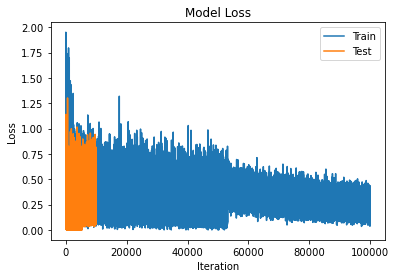

In [63]:
fig, ax = plt.subplots()
itr_result.plot_loss_train_valid_curves(ax)

# Stability Training

First, let's do the training a bit more efficiently.

We'll preproces the images into tensors.

In [21]:
def preprocess_imgs(src_dir):
    location = os.path.join(os.path.abspath(""), "ti200-preprocess")
    try:
        os.mkdir(location)
    except FileExistsError:
        pass
    try:
        os.mkdir(os.path.join(location, "train"))
    except FileExistsError:
        pass
    try:
        os.mkdir(os.path.join(location, "val"))
    except FileExistsError:
        pass
    
    class_names = os.listdir(os.path.join(src_dir, "train"))
    
    for class_name in class_names:
        print(class_name)
        # Deal with training and validation images separately
        old_class_path_train = os.path.join(src_dir, "train", class_name, "images")
        old_class_path_val = os.path.join(src_dir, "val", class_name)
        
        this_class_loc_train = os.path.join(location, "train", class_name)
        try:
            os.mkdir(this_class_loc_train)
        except FileExistsError:
            pass
        this_class_loc_val = os.path.join(location, "val", class_name)
        try:
            os.mkdir(this_class_loc_val)
        except FileExistsError:
            pass
        
        # Iterate through training images
        for img_name in os.listdir(old_class_path_train):
            this_path = os.path.join(old_class_path_train, img_name)
            new_path = os.path.join(
                this_class_loc_train,
                img_name.split(".")[0] + ".pt"
            )
            img_tensor = inception_transform(
                Image.open(this_path).convert("RGB")
            )
            torch.save(img_tensor, new_path)
            
        # Iterate through val images
        for img_name in os.listdir(old_class_path_val):
            this_path = os.path.join(old_class_path_val, img_name)
            new_path = os.path.join(
                this_class_loc_val,
                img_name.split(".")[0] + ".pt"
            )
            img_tensor = inception_transform(
                Image.open(this_path).convert("RGB")
            )
            torch.save(img_tensor, new_path)
    
#preprocess_imgs("Project/tiny-imagenet-200")

We need a new dataset:

In [22]:
class BetterTripletRankingDataset(torch.utils.data.Dataset):
    def __init__(self,
                 img_dir : str,
                 pos_per_img : int,
                 neg_per_pos : int,
                 transform=None,
                 training=True
                ):
        """
        Point at directory which has subdirectories corresponding to
        each class. Supply the number of positive images per image in
        the subdirectories and the number of negative images to combine
        with.
        """
        if transform is None:
            transform = nn.Identity()
        self.transform = transform
        self.mode = "RGB"#ImageReadMode.RGB
        
        #
        # Initialize triplets
        #
        self.triplets = [ ]
        
        if training:
            self._train_init(img_dir, pos_per_img, neg_per_pos)
        else:
            self._val_init(img_dir, pos_per_img, neg_per_pos)
        
    def _train_init(self, img_dir, pos_per_img, neg_per_pos):
        # Generate randoms first, index into later. Need to count
        # Iterate over classes
        class_names = os.listdir(img_dir)
        if os.path.exists(os.path.join(img_dir, class_names[0], "images")):
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x, "images"),
                class_names
            ))
        else:
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x),
                class_names
            ))
        for subdir_path in subdirectories_paths:
            img_per_class = len(os.listdir(subdir_path))
            break
        randoms = np.random.randint(
            0,
            img_per_class,
            (
                len(subdirectories_paths),
                img_per_class,
                pos_per_img,
                neg_per_pos + 1 # Last for positive selection
            ),
            dtype="int16"
        )
        
        # TODO - this method inefficient, only need to hold 2 numbers,
        # some string format info
        # DANGER - potential for loops with symbolic/hard links
        # Iterate over classes
        for subdir_idx, subdir_path in enumerate(subdirectories_paths):
            exclude_subdir_idx =  [
                            *range(subdir_idx),
                            *range(
                                subdir_idx + 1,
                                len(subdirectories_paths)
                            )
                        ]
            # Iterate over images
            for img_idx, img in enumerate(os.listdir(subdir_path)):
                img_path = os.path.join(subdir_path, img)
                # Iterate over alike images
                for pos_it in range(pos_per_img):
                    pos_rand = randoms[subdir_idx][img_idx][pos_it][-1]
                    # Adjust on equal
                    if pos_rand == pos_it:
                        if pos_rand == 0:
                            pos_rand += 1
                        else:
                            pos_rand -= 1
                    # Form name
                    pos_path = os.path.join(
                        subdir_path,
                        f"{class_names[subdir_idx]}_{pos_rand}.pt"
                    )
                    # Need more randoms for next step
                    neg_class_rands = np.random.choice(
                        exclude_subdir_idx,
                        neg_per_pos,
                        replace=True
                    )
                    # Iterate over dissimilar images
                    for neg_it in range(neg_per_pos):
                        class_rand = neg_class_rands[neg_it]
                        neg_class_path = subdirectories_paths[class_rand]
                        neg_class = class_names[class_rand]
                        neg_rand = randoms[subdir_idx][img_idx][pos_it][neg_it]
                        # Form name
                        neg_path = os.path.join(
                            neg_class_path,
                            f"{neg_class}_{neg_rand}.pt"
                        )
                        # Append
                        self.triplets.append((img_path, pos_path, neg_path))
                        
    def _val_init(self, img_dir, pos_per_img, neg_per_pos):
        # Generate randoms first, index into later. Need to count
        # Iterate over classes
        class_names = os.listdir(img_dir)
        
        if os.path.exists(os.path.join(img_dir, class_names[0], "images")):
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x, "images"),
                class_names
            ))
        else:
            subdirectories_paths = list(map(
                lambda x : os.path.join(img_dir, x),
                class_names
            ))
            
        img_per_class = dict()
        img_names = []
        for idx in range(len(class_names)):
            subdir_path = subdirectories_paths[idx]
            class_name = class_names[idx]
            img_names.append(list(os.listdir(subdir_path)))
            img_per_class[class_name] = len(img_names[-1])
        
        # TODO - this method inefficient, only need to hold 2 numbers,
        # some string format info
        # DANGER - potential for loops with symbolic/hard links
        # Iterate over classes
        for subdir_idx, subdir_path in enumerate(subdirectories_paths):
            exclude_subdir_idx =  [
                            *range(subdir_idx),
                            *range(
                                subdir_idx + 1,
                                len(subdirectories_paths)
                            )
                        ]
            this_dir = img_names[subdir_idx]
            # Iterate over images
            for img_idx, img in enumerate(this_dir):
                img_path = os.path.join(subdir_path, img)
                # Iterate over alike images
                for pos_it in range(pos_per_img):
                    # Form name
                    rand_idx = np.random.choice([
                        *range(pos_it),
                        *range(pos_it + 1, img_per_class[class_names[pos_it]])
                    ])
                    pos_name = this_dir[rand_idx]
                    # Form path
                    pos_path = os.path.join(subdir_path, pos_name)
                    # Need more randoms for next step
                    neg_class_rands = np.random.choice(
                        exclude_subdir_idx,
                        neg_per_pos,
                        replace=True
                    )
                    # Iterate over dissimilar images
                    for neg_it in range(neg_per_pos):
                        class_rand = neg_class_rands[neg_it]
                        neg_class_path = subdirectories_paths[class_rand]
                        neg_class = class_names[class_rand]
                        # Select from the directory
                        neg_name = np.random.choice(img_names[class_rand])
                        # Form name
                        neg_path = os.path.join(neg_class_path, neg_name)
                        # Append
                        self.triplets.append((img_path, pos_path, neg_path))
        
    def __len__(self):
        return len(self.triplets)
    
    @lru_cache(maxsize=256)
    def __getitem__(self, idx):
        this_triplet = self.triplets[idx]
        #query = self.transform(read_image(this_triplet[0], self.mode))
        #positive = self.transform(read_image(this_triplet[1], self.mode))
        #negative = self.transform(read_image(this_triplet[2], self.mode))
        query = self.transform(this_triplet[0])
        positive = self.transform(this_triplet[1])
        negative = self.transform(this_triplet[2])
        return query, positive, negative

In [23]:
batch_size = 32

In [24]:
train_path = os.path.join(os.path.abspath(""), "Project", "ti200-preprocess", "train")
val_path = os.path.join(os.path.abspath(""), "Project", "ti200-preprocess", "train")
print(train_path, val_path)
trd_val = BetterTripletRankingDataset(
    val_path,
    1,
    1,
    transform=(lambda x : torch.load(x)),
    training=False
)

batch_size = 32
tr_val_loader = torch.utils.data.DataLoader(trd_val, batch_size=batch_size,
                                     num_workers=0)

C:\Users\Gabriel\Documents\Winter2022\CIS472\Project\ti200-preprocess\train C:\Users\Gabriel\Documents\Winter2022\CIS472\Project\ti200-preprocess\train


Prepare new model that maps into a 64 dimensional encoding space. Note that this is less than the 200 classes.

In [25]:
stability_inception_encoder = torchvision.models.inception_v3(
    pretrained=True,
    aux_logits=False
)

In [26]:
# Set them all to frozen by default
for param in stability_inception_encoder.parameters():
    param.requires_grad = False

In [27]:
# Let's thaw some layers
for param in stability_inception_encoder.Mixed_7c.parameters():
    param.requires_grad = True

In [28]:
stability_inception_encoder.fc = nn.Linear(2048, 64) # 64-Dimensional Encoding

stability_inception_triplet_ranking = TripletRanker(
    stability_inception_encoder
).to(device)

stability_inception_triplet_ranking = StabilityTrainingModel(
    stability_inception_triplet_ranking
)

Training controllers:

In [29]:
sitr_optimizer = optim.Adam(
    stability_inception_triplet_ranking.parameters(),
    lr=0.005,
    betas=(0.8,0.99)
)

Result:

In [30]:
sitr_result = TrainResult(stability_inception_triplet_ranking)

Triplet loss:

In [31]:
ALPHA = 0.01

triplet_loss = nn.TripletMarginLoss(1.0, 2)
triplet_stability_loss = T.Lambda(
    lambda x : \
        (x[0][0] - x[1][0]).norm() + (x[0][1] - x[1][1]).norm() + (x[0][2] - x[1][2]).norm()
)

def sitr_loss(clean_output, distort_output):
    """Note that this will apply softmax to distort_output."""
    return (
        triplet_loss(*clean_output)
        + ALPHA * triplet_stability_loss((clean_output, distort_output))
    )

Training loop:

In [32]:
sitr_best_loss = float("inf")
sitr_best_count = 0

In [ ]:
# Train for some number of epochs
SITR_EPOCH_COUNT = 8
SITR_SAVE_PERIOD = 1

loss = torch.Tensor([0])
for epoch in tqdm_variant(
    range(SITR_EPOCH_COUNT),
    desc=f"Epoch",
    unit="epoch",
    disable=False
):
    # For this training loop, we'll switch up the data each time.
    print("Loading data...")
    try:
        del trd, tr_train_loader
    except NameError:
        pass
    trd = BetterTripletRankingDataset(
        train_path,
        1,
        1,
        transform=(lambda x : torch.load(x))
    )
    tr_train_loader = torch.utils.data.DataLoader(
        trd,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    print("...done.")
    
    # Debug learning rate
    print(f"Current Learning Rate: {sitr_optimizer.param_groups[0]['lr']}")
    
    train_loss = triplet_epoch(
        stability_inception_triplet_ranking,
        tr_train_loader,
        sitr_optimizer,
        device,
        sitr_loss,
        sitr_result
    )

    val_loss = triplet_epoch(
        stability_inception_triplet_ranking,
        tr_val_loader,
        sitr_optimizer,
        device,
        sitr_loss,
        sitr_result,
        training=False
    )
    
    # Save a copy for safety
    if val_loss < sitr_best_loss:
        torch.save(
            stability_inception_triplet_ranking, 
            os.path.join(
                os.path.abspath(""),
                f"best_sitr_{sitr_best_count}_{int(time.time()) % 1000000:06}.pt"
            )
        )
        sitr_best_count += 1
        sitr_best_loss = val_loss
        
    if epoch % SITR_SAVE_PERIOD == SITR_SAVE_PERIOD - 1:
        torch.save(
            inception_triplet_ranking,
            os.path.join(
                os.path.abspath(""),
                f"sitr_{epoch}_{int(time.time()) % 1000000:06}.pt"
            )
        )

    # Print the last loss calculated and the epoch
    print(f"\nEpoch {epoch}: Training Loss: {train_loss}, " \
          f"Validation Loss: {val_loss}")

Epoch:   0%|          | 0/8 [00:00<?, ?epoch/s]

Loading data...
...done.
Current Learning Rate: 0.005


Training Iteration:   0%|          | 0/3125 [00:00<?, ?it/s]

Let's double check gradient calculations went well:

The old way of saving is taking up lots of memory, let's just save the part that changes:

In [59]:
torch.save(
    inception_triplet_ranking.model.state_dict(),
    "inception_triplet_ranking_2.pth"
)

In [60]:
itr_result.save(_def_save_filename)

Let's also take a look at training/testing curves:

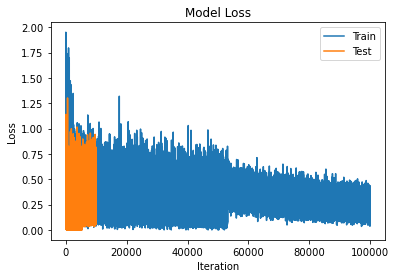

In [63]:
fig, ax = plt.subplots()
itr_result.plot_loss_train_valid_curves(ax)

### Feature Distances

First, run the experiment:

In [56]:
baseline_observations, stabilized_observations = make_observations(
    inception_triplet_ranking.model.to("cpu"),
    None,
    os.path.join(os.path.abspath(""), "tiny-imagenet-200", "test", "images")
)

  0%|          | 0/10001 [00:00<?, ?it/s]

Plot the results:

C:\Users\Gabriel\AppData\Local\Temp/ipykernel_1128/2350893480.py:32: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax.set_yticklabels(
C:\Users\Gabriel\AppData\Local\Temp/ipykernel_1128/2350893480.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


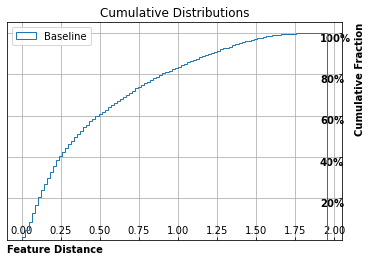

In [65]:
plot_cumulative_dist(
    list(map(lambda x : x.item(), baseline_observations)),
    stabilized_observations
)

Save the results for later:

In [58]:
with open(
    f"inception_tr_distribution_result_{int(time.time()) % 1000000:06}.pt",
    "wb"
) as file_obj:
    pickle.dump(
        {
            "baseline" : baseline_observations,
            "stabilized" : stabilized_observations
        }, file_obj
    )